(fw-model)=
# Forward model

## Introduction
The training data was generated in {cite}`Huntemann2014`. It consists of modeled
ice thickness increase from a cumulative freezing degree day model for the
freeze-up in 2010 in the Kara and Barents Seas.  In this document we are using the
data from {term}`SMOS` which, like {term}`CIMR` observes brightness temperatures at L-band and the cumulative freezing degree day model to fit an
analytic equation to the dependency of brightness temperature and ice thickness.
In contrast to {cite}`Huntemann2014`, here instead of the Intensity and
Polarization difference, the horizontal and vertical polarized brightness
temperatures are used directly.

## Fit from a sea ice thickness dataset
An empirical model of the ice thickness increase was proposed with the so-called cumulative freezing degree days {cite}`Bilello1961`. The
idea is that the integration of negative air temperatures over time is a proxy for the physical ice
thickness increase. The original formulation is 

$$
d_{\text{ice}}(\Theta) = 1.33{\Theta}^{-0.58}
$$ (eq:CFDD_SIT)

$$\Theta = \sum_{\text{days}} T_{\text {air}}+1.8\ {}^\circ \text C \text ,
$$ (eq:CFDD)

with $T_{air}$ being the daily average air temperature. The exponent of
$\Theta$ in equation {eq}`eq:CFDD_SIT` was found to vary depending on the
location, snow accumulation and wind and cloud conditions {cite}`Bilello1961`.
The air temperature used to calculate for $\Theta$ here originate from
NCEP/NCAR reanalysis {cite}`Kalnay1996a`. The 1.8°&nbsp;C offset is here to compensate for the freezing temperature of sea water at typical salinities.

The dataset was acquired in 2010 in the Kara and Barents Seas. The dataset here
is treated differently compared to {cite}`Huntemann2014` in two points
* From the initial 10 small subregions only regions 3, 6, and 7 were used to obtain 
the original fit parameters, here all regions are used.
* The original retrieval removed the 0&nbsp;cm ice thickness, i.e., open water
 cases in the fit, due to instability in fitting procedure for the polarization
 difference $Q$, these open water points are now included here.

The extraction of brightness temperature for the fit procedure and
algorithm development had to be re-evaluated at an incidence angle of 53° for
this document since the incidence angle for previous fit attempts where
different with {cite}`Huntemann2014` being 40°-50° average, and {cite}`Patilea2019` using 40°.

```{note}
The actual incidence angle of CIMR at L-band is closer to 52° than to 53°. The fit here in this ATBD is still optimized for 53° which is partly compensated by the {ref}`OZA`.
```

In [14]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
includet("../algorithm/CIMR_IO_tools.jl")
using CSV
using LaTeXStrings
using Printf
using PythonPlot 
using DataFrames
#using Distributions
using LsqFit
using Markdown
using Printf
import YAML
using Statistics


  Activating project at `/mnt/pharoshome/huntemann/Projects/DEVALGO/SeaIceThickness_ATBD_V2/sit_atbd_env_jl`


In [2]:
using PythonCall
mpl=pyimport("matplotlib")
#mpl.use("Agg")
mpl.use("svg")
#mpl.use("module://juliacall.matplotlib") #some workaround for inline plotting
plt=pyimport("matplotlib.pyplot")
ccrs=pyimport("cartopy.crs")

Python: <module 'cartopy.crs' from '/mnt/pharoshome/huntemann/Projects/DEVALGO/SeaIceThickness_ATBD_V2/sit_atbd_env_jl/.CondaPkg/env/lib/python3.11/site-packages/cartopy/crs.py'>

In [3]:
all_regions_locs=
[  7.6849991e+001,  4.2563492e+001],
[  7.8344194e+001,  4.7455311e+001],
[  7.8714499e+001,  5.7407954e+001],
[  7.8378661e+001,  6.6654149e+001],
[  7.8337631e+001,  7.4859558e+001],
[  7.7374017e+001,  8.1712057e+001],
[  7.5811001e+001,  7.9569564e+001],
[  7.4850015e+001,  6.9278851e+001],
[  7.3124055e+001,  6.1770532e+001],
[  7.1849906e+001,  6.0701303e+001]

([76.849991, 42.563492], [78.344194, 47.455311], [78.714499, 57.407954], [78.378661, 66.654149], [78.337631, 74.859558], [77.374017, 81.712057], [75.811001, 79.569564], [74.850015, 69.278851], [73.124055, 61.770532], [71.849906, 60.701303])

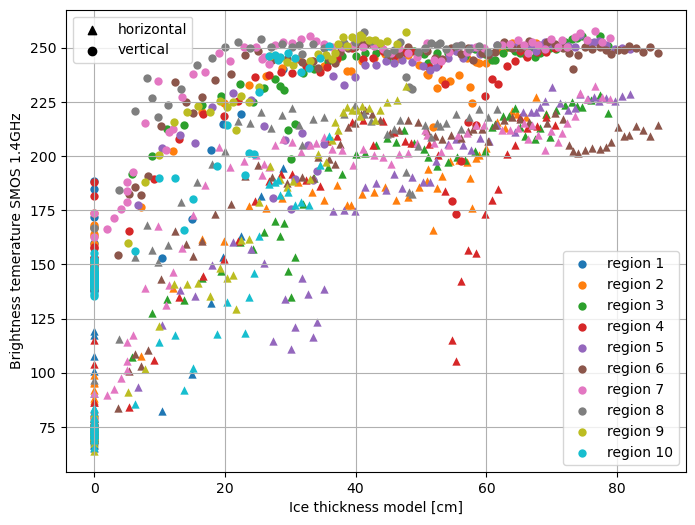

~~~markdown
```{figure} figures/figure_fig:tbsmos.png
:name: fig:tbsmos

Ice thickness to brightness temperature relation showing the original SMOS data for the three resions from {cite}`Huntemann2014` extracted at 53° incidence angle.
```

~~~

In [15]:
airt=CSV.read("../data/sit_ncep.txt",DataFrame,limit=87)
all_regions_dfs=Dict{Int64,DataFrame}()
#plot(size=(800,600))
regions=1:10
for i=regions
#    @show @sprintf "../data/region%02i_53.txt" i
    all_regions_dfs[i]=CSV.read((@sprintf "../data/region%02i_53_724.txt" i),DataFrame)
end


fig=plt.figure(figsize=[8,6])
ax=fig.add_subplot(111)
cmap = plt.get_cmap("tab10")
litems=[]
lnames=[]
ax.grid()
for i=regions
    p1=ax.scatter(airt[!,"region$i"],all_regions_dfs[i].TBh,marker="^",lw=0,color=cmap(i-1),label="")#L"region %$i $T_{b,h}")
   push!(litems,ax.scatter(airt[!,"region$i"],all_regions_dfs[i].TBv,marker="o",lw=0,color=cmap(i-1),label="region $i"))
    push!(lnames,"region $i")
end
#plt.c
#plot!(legend=:bottomright)
#plot!(legendfontsize=10)
ax.set_xlabel("Ice thickness model [cm]")
ax.set_ylabel("Brightness temerature SMOS 1.4GHz")
leg1=ax.legend(litems,lnames,loc="lower right")

leg2=ax.legend([ax.scatter([],[],marker=d,color="black") for d in "^o"],["horizontal","vertical"],loc="upper left")
fig.add_artist(leg1)

#ax.twinx()
#ax.tw
#scatter!([1],[0],marker=:utriangle,color="black",label=L"$T_{b,h}$")
#scatter!([1],[0],marker=:circ,color="black",label=L"$T_{b,v}$")
#ylims!(50,260)
#display(fig)
plot_with_caption(fig, "Ice thickness to brightness temperature relation showing the original SMOS data for the three resions from {cite}`Huntemann2014` extracted at 53° incidence angle.", "fig:tbsmos")

{numref}`fig:tbsmos` gives a nice relation between ice thickness and the brightness temperatures in horizontal and vertical polarization. Horizontal shows a slower increase and later saturation but is subject to more noise in general. For the fitting procedure 0&nbsp;cm ice thickness, i.e. open water, is included.
The individual regions are shown in {numref}`fig:kararegions`. The regions in {numref}`fig:tbsmos` and {numref}`fig:kararegions` are corresponding according to their color. Most regions are located East to North-East of Novaya Zemlya in the Kara Sea but some regions are also located North-West of Novaya Zemlya in the Barents Sea.



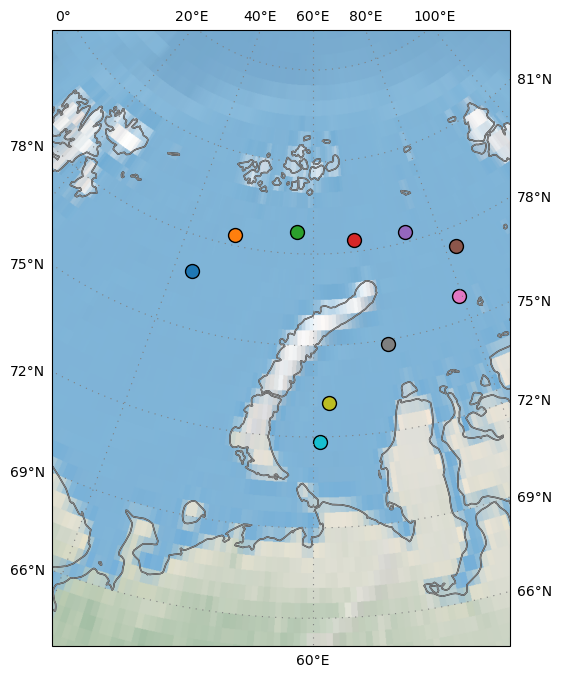

~~~markdown
```{figure} figures/figure_fig:kararegions.png
:name: fig:kararegions

Regions in the Kara and Barents Seas from the 2010 training data.
```

~~~

In [16]:
mycrs=ccrs.LambertAzimuthalEqualArea(central_latitude=90,central_longitude=60)
fig=plt.figure(figsize=[8,8])
ax=fig.add_subplot(111,projection=mycrs)
ax.coastlines()
ax.gridlines(draw_labels=true,color="gray",linestyle=(0, (1, 5,)))
ax.set_extent((40,75,65,85),crs=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines("50m",color="gray")
for i=regions
ax.plot(all_regions_locs[i][2],all_regions_locs[i][1],lw=0,marker="o",transform=ccrs.PlateCarree(),mec="black",ms=10)
end

plot_with_caption(fig,"Regions in the Kara and Barents Seas from the 2010 training data.","fig:kararegions")

In [6]:
alltbh=collect(skipmissing(vcat([all_regions_dfs[i].TBh for i=regions]...)))
nanidx=isnan.(alltbh)

alltbv=collect(skipmissing(vcat([all_regions_dfs[i].TBv for i=regions]...)))
allsit=vcat([airt[!,"region$i"] for i=regions]...);

#nanidx.|=(allsit.==0)
alltbh=alltbh[.!nanidx]
alltbv=alltbv[.!nanidx]
allsit=allsit[.!nanidx];


## Parameter estimation
As a fit function a simple exponential is used with 

$$
f_p(x)= p_2 - (p_2 - p_1)\exp(-x/p_3)
$$ (eq:intensity)

where $p_1$ is effectively the brightness temperature of open water close to sea ice under freezing conditions, $p_2$ is the brightness temerature of thick sea ice, and $p_3$ is a curvature parameter connecting the two TBs. The index $p$ of $f_p$ indicates the polarization, either $h$ or $v$.



The parameters $p_i$ are optained in a fit to the data from the ten regions mentioned. 
A least square fit of equation {eq}`eq:intensity` for $T_{b,h}$ and $T_{b,v}$ individually gives 6 parameters in total.
The same can be done in intensity and polarization difference space while for polarization difference another fit formula is used

$$
f_Q(x)= p_2 - (p_2 -p_1)\exp(-(x/p_3)^{p_4})
$$ (eq:poldiff)

To compare the ice thickness to brightness temperature relation based on the new fit parameters, the original fit parameters have to be recalculated for the 53° incidence angle of CIMR. This gives 7 parameters for the recalculation of the original fit, with an additional parameter $p_4$ for the polarization difference fit. The fit parameters are given in {numref}`retrieval parameters`.


In [7]:
@. ff(x,p)=p[2]-(p[2]-p[1])*exp(-x/p[3])
@. fq(x,p)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])
ph=curve_fit(ff,allsit,alltbh,[70.0,200.0,0.12]).param
pv=curve_fit(ff,allsit,alltbv,[70.0,200.0,0.12]).param
pI=curve_fit(ff,allsit,alltbh./2+alltbv./2,[70.0,200.0,0.12]).param
pQ=curve_fit(fq,allsit,alltbv.-alltbh,[70.0,20.0,0.12,0.4]).param
t(n)=@sprintf "%.3f" n


"""```{table} Fit parameters for intensity and polarization difference
:name: "retrieval parameters"

| parameter | \$p_1\$ | \$p_2\$ | \$p_3\$ | \$p_4\$ |
| --- | --- | --- | --- | --- | 
| horizontal \$T_{b,h}\$ | $(t(ph[1])) | $(t(ph[2])) | $(t(ph[3])) |   |
| vertical \$T_{b,v}\$| $(t(pv[1])) | $(t(pv[2])) | $(t(pv[3])) |    |
| intensity \$I=(T_{b,v}+T_{b,h})/2\$| $(t(pI[1])) | $(t(pI[2])) | $(t(pI[3])) |    |
| polarization difference \$Q=(T_{b,v}-T_{b,h})\$| $(t(pQ[1])) | $(t(pQ[2])) | $(t(pQ[3])) | $(t(pQ[4])) | 
""" * "```"|> x->display("text/markdown",x)

```{table} Fit parameters for intensity and polarization difference
:name: "retrieval parameters"

| parameter | $p_1$ | $p_2$ | $p_3$ | $p_4$ |
| --- | --- | --- | --- | --- | 
| horizontal $T_{b,h}$ | 74.527 | 217.795 | 21.021 |   |
| vertical $T_{b,v}$| 145.170 | 247.636 | 12.509 |    |
| intensity $I=(T_{b,v}+T_{b,h})/2$| 109.891 | 231.596 | 16.829 |    |
| polarization difference $Q=(T_{b,v}-T_{b,h})$| 71.086 | 34.322 | 38.731 | 2.142 | 
```

## Comparison between $I-Q$ and $h-v$ fit
A resulting fit through all data points show that also the direct horizontal and vertical fits are suitable for representation of ice thickness to brightness temperature relation, similar to the originally $I-Q$ fit from {cite}`Huntemann2014`. The fit parameters are given in {numref}`retrieval parameters`. The comparison of a $I-Q$ fit and a $T_{b,v} - T_{b,h}$ fit is shown in {numref}`fig:fitcomparison`. Only a slight difference is seen in $T_{b,h}$ at higher ice thickness.

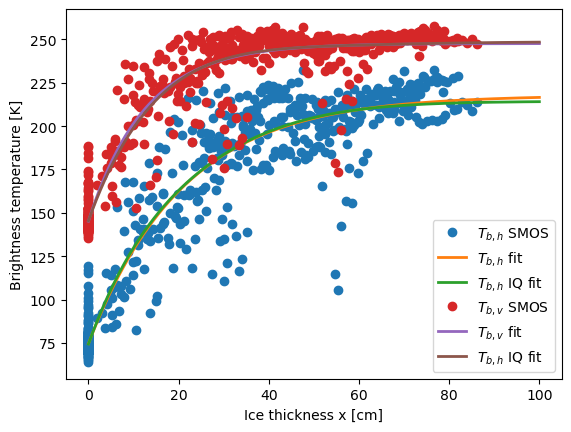

~~~markdown
```{figure} figures/figure_fig:fitcomparison.png
:name: fig:fitcomparison

Comparison of brightness temperature fits for horizontal and vertical polarizations against ice thickness.
```

~~~

In [17]:
xx=0:0.1:100.0

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(allsit,alltbh,lw=0,marker="o",label=L"$T_{b,h}$ SMOS")
ax.plot(xx,ff(xx,ph),lw=2,label=L"$T_{b,h}$ fit")
ax.plot(xx,ff(xx,pI).-fq(xx,pQ)./2,lw=2,label=L"$T_{b,h}$ IQ fit")

ax.plot(allsit,alltbv,lw=0,marker="o",label=L"$T_{b,v}$ SMOS")
ax.plot(xx,ff(xx,pv),lw=2,label=L"$T_{b,v}$ fit")
ax.plot(xx,ff(xx,pI).+fq(xx,pQ)./2,lw=2,label=L"$T_{b,h}$ IQ fit")
ax.legend(loc="lower right")

ax.set_xlabel("Ice thickness x [cm]")
ax.set_ylabel("Brightness temperature [K]")
plot_with_caption(fig,"Comparison of brightness temperature fits for horizontal and vertical polarizations against ice thickness.","fig:fitcomparison")

The relation for polarization difference, i.e. $T_{b,v} - T_{b,h}$ to ice
thickness, shows also good agreement with the data in both fit variants in
{numref}`fig:qfitcomp`. However, some differences are visible for thin ice and
in the extrapolation to higher thicknesses. The increase of polarization
difference after the initial freeze-up, between 5&nbsp;cm and 10&nbsp;cm ice thickness, seems
physically plausible as calming of seawater results in smaller sea surface
roughness and thus increased polarization difference. This is not captured by
the $I-Q$ fit functions as the {eq}`eq:poldiff` is constrained in this regard.

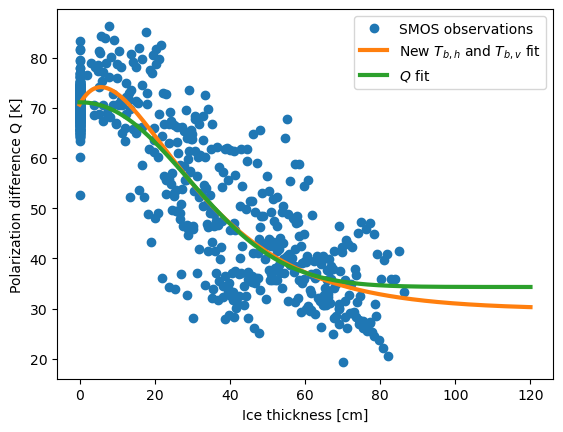

~~~markdown
```{figure} figures/figure_fig:qfitcomp.png
:name: fig:qfitcomp

Comparison of polarization difference fits against ice thickness.
```

~~~

In [18]:
xx=0:0.01:120
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(allsit,alltbv.-alltbh,lw=0,marker="o", label="SMOS observations")
ax.plot(xx,ff(xx,pv).-ff(xx,ph),lw=3,label=L"New $T_{b,h}$ and $T_{b,v}$ fit")
ax.plot(xx,fq(xx,pQ),lw=3,label=L"$Q$ fit")

ax.set_ylabel("Polarization difference Q [K]")
ax.set_xlabel("Ice thickness [cm]")
ax.legend()
plot_with_caption(fig,"Comparison of polarization difference fits against ice thickness.","fig:qfitcomp")

The polarization difference plotted versus intensity, which is the original
representation used by {cite}`Huntemann2014` and {cite}`Patilea2019` also shows
that the fit is appropriate in the $I-Q$-space in {numref}`fig:IQcomp`. The most
notable difference is the same as in the {numref}`fig:qfitcomp` figure, i.e. the
increase of polarization difference after the initial freeze-up, in the 5-10&nbsp;cm
regime. The highest ice thickness displayed here is 120&nbsp;cm, which is a
extrapolation for the current fit and comes with an extra uncertainty.

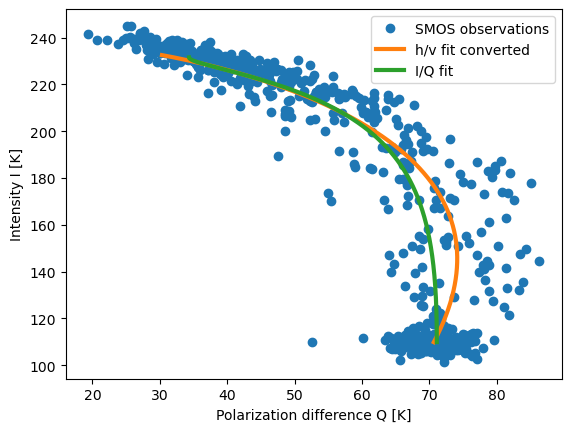

~~~markdown
```{figure} figures/figure_fig:IQcomp.png
:name: fig:IQcomp

Comparison of fits in intensity vs. polarization difference space.
```

~~~

In [19]:
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(alltbv.-alltbh,alltbv./2 +alltbh./2,lw=0,marker="o",label="SMOS observations")
ax.plot(ff(xx,pv).-ff(xx,ph),ff(xx,pv)./2 .+ff(xx,ph)./2,lw=3,label="h/v fit converted")
ax.plot(fq(xx,pQ),ff(xx,pI),lw=3,label="I/Q fit")

ax.set_xlabel("Polarization difference Q [K]")
ax.set_ylabel("Intensity I [K]")
ax.legend()
plot_with_caption(fig,"Comparison of fits in intensity vs. polarization difference space.","fig:IQcomp")

In [21]:
YAML.write_file("fit_params.yml", Dict("ph"=>ph,"pv"=>pv, "pI"=>pI, "pQ"=>pQ))


(OZA)=
## Correction for variation in incidence angle
While the algorithm is designed for a fixed incidence angle, the incidence
angle is varying slightly depending on the feed horn which is used for the
observation which, in turn, changes the brightness temperatures. We attempt a straightforward correction for the incidence angle dependence of the
brightness temperatures by estimating the surface reflectivity using the
polarization information for a given observation. The assumption here is a
simple Fresnel reflection model without an atmospheric contribution. First, we
define the Fresnel reflection coefficient of the surface with given effective
permittivity $\varepsilon$ and incidence angle $\theta_i$ as 
```{math}
:label: eq:em_ocean
E_{0p} &= 1-|r_p|^2\\ 
r_v &= \frac{ε\cos(θ_i)-\sqrt{ε-\sin^2(θ_i)}}{ε\cos(θ_i)+\sqrt{ε-\sin^2(θ_i)}}\\
r_h &= \frac{\cos(θ_i)-\sqrt{ε-\sin^2(θ_i)}}{\cos(θ_i)+\sqrt{ε-\sin^2(θ_i)}}
```

The effective permittivity is used here which is a simplification calculated with the assumption that the atmosphere is transparent. We use an effective surface temperature $T_{\text{eff}}$ which we set to $T_{\text{eff}}=240$ if $T_{b,v}<220$ K otherwise it is set to $T_{\text{eff}}=T_{b,v}+20$ K as an approximation. Then we have
```{math}
:label: eq:eff_temp
T_{\text{eff}} = \frac{T_{b,h}(θ_i) \cdot (1-r_h(ε,θ_i)) + 
T_{b,v}(θ_i)\cdot(1-r_v(ε,θ_i))}{2}
```
which we can solve for a given $θ_i$ to get the effective permittivity as
```{math}
:label: eq:eff_eps
ε_{\text{eff}} = \operatorname{arg\,min}_{ε \in \mathbb{R}} \left| \left( \frac{T_{b,h}(θ_i)}{T_{\text{eff}}} - (1-r_h(ε,θ_i))\right)^2 +
\left( \frac{T_{b,v}(θ_i)}{T_{\text{eff}}} - (1-r_v(ε,θ_i))\right)^2 \right|
```
The corrected brightness temperature for the incidence angle $θ_{\text{ref}}$ at vertical polarization is then given by
```{math}
:label: eq:incidence
T_{b,p}(θ_{\text{ref}}) =  T_{b,p}(\theta) + \left(r_p(ε_{\text{eff}},θ_{\text{ref}}) - r_p(ε_{\text{eff}},θ)\right) \cdot ζ
```

with $θ$ being the incidence angle of the observation. In theory, we expect the correction factor $ζ$ to be equal to the effective temperature $T_{\text{eff}}$ which approximately fits for L-band at both polarizations. This allows us to compensate the brightness temperatures for small variation in incidence angle, improving the accuracy of our ice thickness estimations.

# CIMR Level-1b re-sampling approach

The CIMR Level-1b data is resampled using a nearest neighbor interpolation onto the output grid. Since the SIT retrieval only uses one single channel (L-band) there is no interpolation needed for bringing different frequencies together as input for the algorithm.

# Algorithm Assumptions and Simplifications

The CIMR SIT algorithm described here is designed to be used in high sea ice concentration areas, with little to no open water contamination within the L-band footprint. This is not always the case, in particular at the ice edges. The impact of the sea ice concentration on the SIT retrieval is discussed in {ref}`concentration_influence`. 
Similarly costal contamination is not considered in the algorithm and any form of costal influence within the footprint would show as higher sea ice thickness, as the brightness temperatures of land surfaces are closer to that of thick sea ice than to open water. As a consequence, the retrieval may show coastal contamination in the area around land surfaces which show up as increased ice thickness, creating the impression that all land surfaces are surrounded by thin sea ice. There are several way to deal with this effect in the final product
* External information about costal contamination of the L-band footprint which is currently not provided in the L1b data (depends on location and azimuth angle)
* Masking a region around land surface where the retrieval is not applied and the product yield NaN values (most conservative)
* Propagating closest valid values into regions close to coast, while the exact distance need to be determined from real CIMR data.

# Level-2 end to end algorithm functional flow diagram

```{mermaid}

graph TD
    B[Input CIMR Level-1b data] --> C[Preprocess data]
    C --> D[Apply incidence angle homogenization]
    D --> E[Apply SIT retrieval]
    D --> F[Apply SIT uncertainty calculation]
    E --> G[Calculate flags]
    D --> E
    F --> G
    E --> H[Resampling to output L2 file]
    F --> H
    G --> H
```

# Functional description of each Algorithm step

The processing chain works as follows:
The processing chain works as follows:
1. **Input CIMR Level-1b data**: The algorithm begins by ingesting the raw Level-1b data from the CIMR satellite, which includes brightness temperature measurements at L-band frequencies.
2. **Preprocess data**: The data is preprocessed to remove any noise and correct for any known biases or errors in the measurements. This step may include filtering and calibration to ensure the data quality is suitable for further analysis.
3. **Apply incidence angle homogenization**: A correction is applied to account for variations in the incidence angle of the observations. This involves estimating the effective permittivity and adjusting the brightness temperatures based on the Fresnel reflection model (see {ref}`OZA`)
4. **Apply SIT retrieval**: The SIT retrieval algorithm is executed, utilizing the corrected brightness temperatures to estimate the thickness of the sea ice. This step involves fitting the brightness temperature data to the established models for both horizontal and vertical polarizations (see {ref}`retrieval_def`)
5. **Apply SIT uncertainty calculation**: Uncertainty estimates are calculated for the SIT retrievals, taking into account the variability in the input data and the assumptions made during the retrieval process (see {ref}`uncertainties`).
6. **Calculate flags**: Flags are generated to indicate the quality of the retrievals, including any potential issues such as coastal contamination or low confidence in the SIT estimates.
7. **Resampling to output L2 file**: Finally, the processed data, including the SIT estimates, uncertainty values, and quality flags, are compiled into a Level-2 output file for further analysis and dissemination.

# 